# Batch size = 32k, lr = 3e-4, cleaned data

In [24]:
CATEGORY = "Video_Games"

In [25]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(PROJECT_ROOT))

# Data directory
DATA_DIR = Path(PROJECT_ROOT, "data")
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR = DATA_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

In [26]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch

import wandb
from src.logger import setup_logger
from src.train_rqvae import RQVAE, RQVAEConfig

In [27]:
logger = setup_logger("get-semantic-ids-per-asin")

In [ ]:
#artifact_path = f"eugeneyan/rqvae/rqvae-best-{CATEGORY}:v1882"
artifact_path = f"kellyweiyangwang-peking-university/rqvae/rqvae-best-{CATEGORY}:v0"
version = artifact_path.split(":")[-1]

In [29]:
run = wandb.init()
artifact = run.use_artifact(artifact_path, type="model")
artifact.download(MODELS_DIR)

old_path = MODELS_DIR / "best_model.pth"
new_path = MODELS_DIR / f"rqvae_video_games_{version}.pth"
shutil.move(str(old_path), str(new_path))
logger.info(f"Model downloaded to {new_path}")

wandb:   1 of 1 files downloaded.  


22:33:38 - Model downloaded to /Users/bytedance/Documents/code/semantic-ids-llm/data/models/rqvae_video_games_v1882.pth


## Load model and get semantic IDs per ASIN

In [30]:
# Load model function
def load_rqvae_model(model_path: str, device: str = None):
    """Load RQVAE model from checkpoint."""

    # Auto-detect device if not specified
    if device is None:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    # Extract config from checkpoint
    if "config" in checkpoint:
        # Config might be a RQVAEConfig object or a dict
        config_dict = checkpoint["config"]
        logger.info(f"Config dict: {config_dict}")

        # If it's already a RQVAEConfig object, use it directly
        if isinstance(config_dict, RQVAEConfig):
            config = config_dict
        else:
            # If it's a dict, we need to handle it differently
            # The saved config might be the entire dataclass as dict
            config = RQVAEConfig()  # Create default config
            logger.info(f"Config data: {config}")

            # Update only the model-related parameters that RQVAE actually uses
            if isinstance(config_dict, dict):
                for key, value in config_dict.items():
                    if hasattr(config, key):
                        setattr(config, key, value)

    # Create model instance with RQVAEConfig object
    model = RQVAE(config)

    # Handle state dict from compiled model
    state_dict = checkpoint["model_state_dict"]

    # Check if this is from a compiled model (keys start with '_orig_mod.')
    if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
        # Remove '_orig_mod.' prefix from all keys
        state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}

    # Load weights
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()

    return model, config, device


# Load the model
model, config, device = load_rqvae_model(str(new_path))
logger.info(f"Model loaded successfully on {device}")
logger.info(f"Model config: {config}")

22:33:38 - Config dict: {'category': 'Video_Games', 'data_dir': PosixPath('data'), 'embeddings_path': PosixPath('data/output/Video_Games_items_with_embeddings.parquet'), 'checkpoint_dir': PosixPath('checkpoints/rqvae'), 'item_embedding_dim': 1024, 'encoder_hidden_dims': [512, 256, 128], 'codebook_embedding_dim': 32, 'codebook_quantization_levels': 3, 'codebook_size': 256, 'commitment_weight': 0.25, 'use_rotation_trick': True, 'use_ema_vq': False, 'ema_decay': 0.99, 'ema_epsilon': 1e-05, 'batch_size': 32768, 'gradient_accumulation_steps': 1, 'num_epochs': 40000, 'scheduler_type': 'cosine_with_warmup', 'warmup_start_lr': 1e-08, 'warmup_steps': 200, 'max_lr': 0.0003, 'min_lr': 1e-06, 'use_gradient_clipping': True, 'gradient_clip_norm': 1.0, 'use_kmeans_init': True, 'reset_unused_codes': True, 'steps_per_codebook_reset': 2, 'codebook_usage_threshold': 1.0, 'val_split': 0.05, 'steps_per_train_log': 10, 'steps_per_val_log': 200}
22:33:38 - Config data: RQVAEConfig(category='Video_Games', dat

In [31]:
# Load embeddings
embeddings_path = DATA_DIR / "output" / "Video_Games_items_with_embeddings.parquet"
logger.info(f"Loading embeddings from {embeddings_path}")

df = pl.read_parquet(embeddings_path)
embeddings = torch.tensor(df["embedding"].to_list(), dtype=torch.float32)
item_ids = df["parent_asin"].to_list()

logger.info(f"Loaded {len(embeddings):,} embeddings of dimension {embeddings.shape[1]}")

22:33:38 - Loading embeddings from /Users/bytedance/Documents/code/semantic-ids-llm/data/output/Video_Games_items_with_embeddings.parquet
22:33:38 - Loaded 1,000 embeddings of dimension 384


In [ ]:
# Extract semantic IDs in batches
batch_size = 1024
all_semantic_ids = []

logger.info("Extracting semantic IDs...")
with torch.no_grad():
    for i in range(0, len(embeddings), batch_size):
        batch = embeddings[i : i + batch_size].to(device)
        semantic_ids = model.encode_to_semantic_ids(batch)
        all_semantic_ids.append(semantic_ids.cpu())

        # Progress logging
        if (i // batch_size + 1) % 10 == 0:
            logger.info(f"  Processed {min(i + batch_size, len(embeddings)):,} / {len(embeddings):,} items")

# Concatenate all results
semantic_ids_tensor = torch.cat(all_semantic_ids, dim=0)
logger.info(f"Extracted semantic IDs shape: {semantic_ids_tensor.shape}")

22:33:38 - Extracting semantic IDs...


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (384x384 and 1024x512)

In [ ]:
# Create output dataframe with semantic IDs
result_df = pl.DataFrame(
    {
        "parent_asin": item_ids[: len(semantic_ids_tensor)],
        "semantic_id_0": semantic_ids_tensor[:, 0].numpy(),
        "semantic_id_1": semantic_ids_tensor[:, 1].numpy(),
        "semantic_id_2": semantic_ids_tensor[:, 2].numpy(),
    }
)

# Show sample
logger.info("Sample semantic IDs:")
result_df.head(10)

NameError: name 'item_ids' is not defined

In [ ]:
# Analyze semantic ID distribution
logger.info("\nSemantic ID Statistics:")
for level in range(3):
    col = f"semantic_id_{level}"
    unique_codes = result_df[col].n_unique()
    logger.info(f"  Level {level}: {unique_codes} unique codes used (out of {config.codebook_size})")

# Check for duplicate semantic IDs
semantic_ids_str = result_df.select(
    pl.concat_str(
        [pl.col("semantic_id_0").cast(str), pl.col("semantic_id_1").cast(str), pl.col("semantic_id_2").cast(str)],
        separator="-",
    ).alias("semantic_id_full")
)
n_unique_full = semantic_ids_str["semantic_id_full"].n_unique()
logger.info(f"\nTotal unique semantic ID combinations: {n_unique_full:,} out of {len(result_df):,} items")
logger.info(f"Proportion of unique IDs: {n_unique_full / len(result_df):.2%}")

22:13:30 - 
Semantic ID Statistics:


NameError: name 'result_df' is not defined

In [ ]:
# Add collision resolution - 4th code for items with same first 3 codes
logger.info("\nResolving semantic ID collisions...")

# Group by the first 3 semantic IDs
collision_groups = (
    result_df.with_row_index("original_order")
    .group_by(["semantic_id_0", "semantic_id_1", "semantic_id_2"])
    .agg([pl.col("parent_asin"), pl.col("original_order"), pl.len().alias("group_size")])
    .sort(["semantic_id_0", "semantic_id_1", "semantic_id_2"])
)

# Show collision statistics
collision_counts = collision_groups.group_by("group_size").agg(pl.len().alias("n_groups")).sort("group_size")
logger.info("Collision statistics:")
for row in collision_counts.iter_rows():
    group_size, n_groups = row
    logger.info(f"  {n_groups:,} semantic ID combinations have {group_size} items")

# Create 4th code for each item
semantic_id_3_list = []

for row in collision_groups.iter_rows():
    sem_id_0, sem_id_1, sem_id_2, asins, orders, group_size = row

    # For each ASIN in this group, assign sequential 4th codes
    for idx, (asin, order) in enumerate(sorted(zip(asins, orders), key=lambda x: x[1])):
        semantic_id_3_list.append((order, idx))

# Sort by original order and extract just the 4th codes
semantic_id_3_list.sort(key=lambda x: x[0])
semantic_id_3_values = [x[1] for x in semantic_id_3_list]

# Add to dataframe
result_df = result_df.with_columns(pl.Series("semantic_id_3", semantic_id_3_values))

# Verify uniqueness
semantic_ids_full = result_df.select(
    pl.concat_str(
        [
            pl.col("semantic_id_0").cast(str),
            pl.col("semantic_id_1").cast(str),
            pl.col("semantic_id_2").cast(str),
            pl.col("semantic_id_3").cast(str),
        ],
        separator="-",
    ).alias("semantic_id_full")
)

n_unique_with_4th = semantic_ids_full["semantic_id_full"].n_unique()
logger.info("After adding 4th code:")
logger.info(f"  Total unique semantic ID combinations: {n_unique_with_4th:,} out of {len(result_df):,} items")
logger.info(f"  Proportion of unique IDs: {n_unique_with_4th / len(result_df):.2%}")

19:44:22 - 
Resolving semantic ID collisions...
19:44:22 - Collision statistics:
19:44:22 -   54,308 semantic ID combinations have 1 items
19:44:22 -   3,408 semantic ID combinations have 2 items
19:44:22 -   660 semantic ID combinations have 3 items
19:44:22 -   232 semantic ID combinations have 4 items
19:44:22 -   104 semantic ID combinations have 5 items
19:44:22 -   51 semantic ID combinations have 6 items
19:44:22 -   32 semantic ID combinations have 7 items
19:44:22 -   21 semantic ID combinations have 8 items
19:44:22 -   18 semantic ID combinations have 9 items
19:44:22 -   10 semantic ID combinations have 10 items
19:44:22 -   6 semantic ID combinations have 11 items
19:44:22 -   8 semantic ID combinations have 12 items
19:44:22 -   4 semantic ID combinations have 13 items
19:44:22 -   5 semantic ID combinations have 14 items
19:44:22 -   2 semantic ID combinations have 15 items
19:44:22 -   4 semantic ID combinations have 16 items
19:44:22 -   2 semantic ID combinations have

In [ ]:
# Create a formatted semantic ID string for easy use
result_df = result_df.with_columns(
    pl.concat_str(
        [
            pl.col("semantic_id_0").cast(str),
            pl.col("semantic_id_1").cast(str),
            pl.col("semantic_id_2").cast(str),
            pl.col("semantic_id_3").cast(str),
        ],
        separator="-",
    ).alias("semantic_id")
)

# Final summary
logger.info("=== Final Semantic ID Summary ===")
logger.info(f"Total items: {len(result_df):,}")
logger.info("Semantic ID format: 4 codes (3 from RQ-VAE + 1 for collision resolution)")
logger.info("All semantic IDs are now unique!")

# Show distribution of 4th code values
fourth_code_dist = result_df.group_by("semantic_id_3").len().sort("semantic_id_3")
logger.info("Distribution of 4th code values:")
for row in fourth_code_dist.head(10).iter_rows():
    code, count = row
    logger.info(f"  Code {code}: {count:,} items")
if len(fourth_code_dist) > 10:
    logger.info(f"  ... and {len(fourth_code_dist) - 10} more values")

# Final sample
logger.info("Final semantic ID format:")
result_df.head(5)

19:44:22 - === Final Semantic ID Summary ===
19:44:22 - Total items: 66,097
19:44:22 - Semantic ID format: 4 codes (3 from RQ-VAE + 1 for collision resolution)
19:44:22 - All semantic IDs are now unique!
19:44:22 - Distribution of 4th code values:
19:44:22 -   Code 0: 58,880 items
19:44:22 -   Code 1: 4,572 items
19:44:22 -   Code 2: 1,164 items
19:44:22 -   Code 3: 504 items
19:44:22 -   Code 4: 272 items
19:44:22 -   Code 5: 168 items
19:44:22 -   Code 6: 117 items
19:44:22 -   Code 7: 85 items
19:44:22 -   Code 8: 64 items
19:44:22 -   Code 9: 46 items
19:44:22 -   ... and 40 more values
19:44:22 - Final semantic ID format:


parent_asin,semantic_id_0,semantic_id_1,semantic_id_2,semantic_id_3,semantic_id
str,i64,i64,i64,i64,str
"""B00064NY44""",191,4,204,0,"""191-4-204-0"""
"""B07TWTD92N""",127,64,30,0,"""127-64-30-0"""
"""B01BO5F1PS""",53,199,104,0,"""53-199-104-0"""
"""B000FE53BC""",141,97,190,0,"""141-97-190-0"""
"""B01940KOLQ""",131,194,36,0,"""131-194-36-0"""


In [ ]:
# See semantic IDs with semnatic ID 3 greater than 1 (but exclude those with semantic ID 3 = 0 or 1)
result_df.filter(pl.col("semantic_id_3") > 1).sort(["semantic_id_0", "semantic_id_1", "semantic_id_2"]).head(10)

parent_asin,semantic_id_0,semantic_id_1,semantic_id_2,semantic_id_3,semantic_id
str,i64,i64,i64,i64,str
"""B08JZ2JQTT""",0,29,187,2,"""0-29-187-2"""
"""B09H5MXW7X""",0,41,150,2,"""0-41-150-2"""
"""B07H88PM88""",0,68,113,2,"""0-68-113-2"""
"""B07FFS1LN7""",0,68,113,3,"""0-68-113-3"""
"""B084YJPYCN""",0,108,2,4,"""0-108-2-4"""
"""B084YPG8MX""",0,108,2,3,"""0-108-2-3"""
"""B084YD6VTD""",0,108,2,5,"""0-108-2-5"""
"""B084YH8HX3""",0,108,2,2,"""0-108-2-2"""
"""B00V2TT47I""",0,118,179,2,"""0-118-179-2"""


## Visualize Semantic ID Distribution

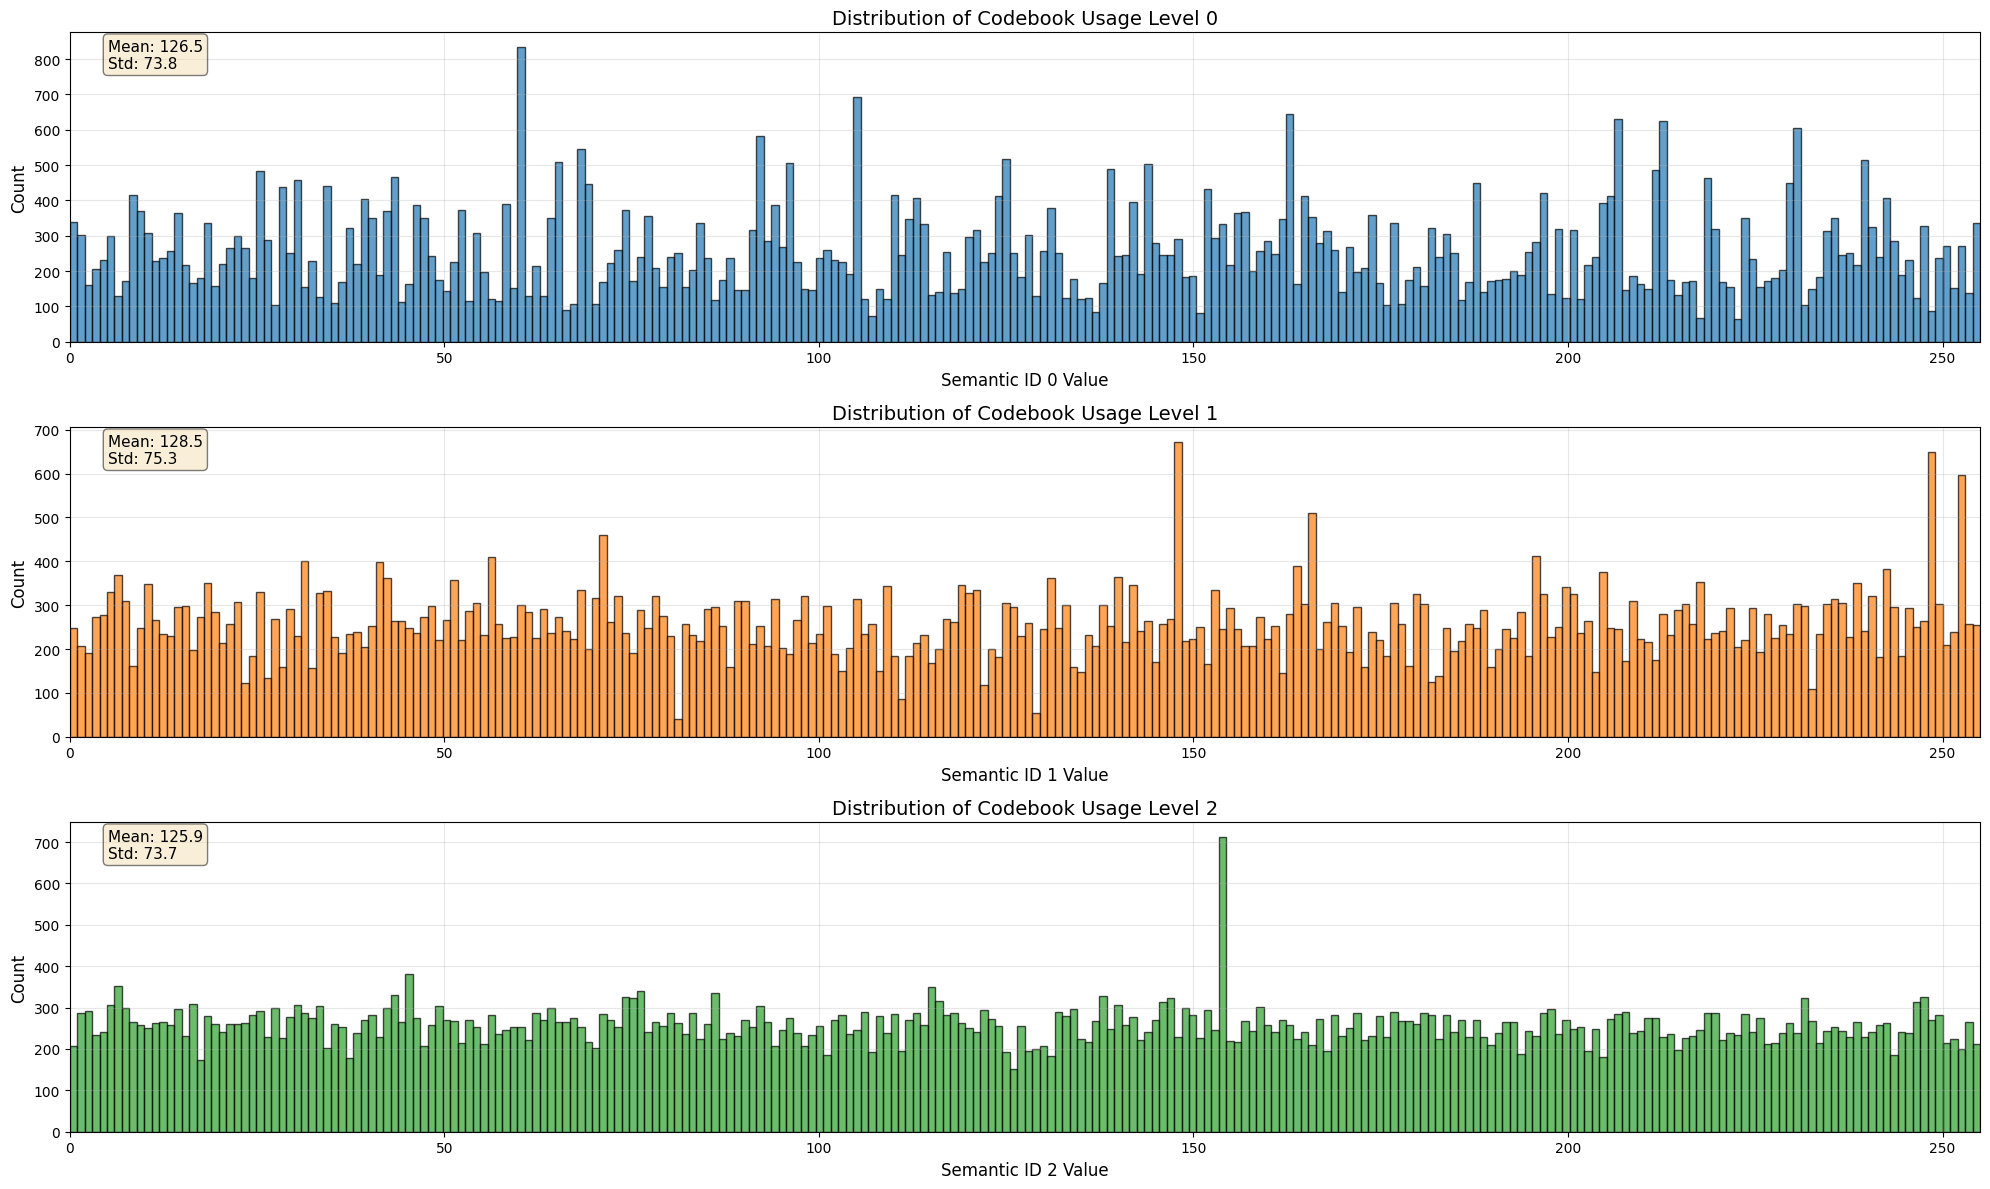

19:44:23 - Semantic ID distribution statistics:
19:44:23 - 
Level 0:
19:44:23 -   Unique values used: 256/256
19:44:23 -   Mean: 126.52
19:44:23 -   Std: 73.80
19:44:23 -   Min count: 65
19:44:23 -   Max count: 834
19:44:23 - 
Level 1:
19:44:23 -   Unique values used: 256/256
19:44:23 -   Mean: 128.45
19:44:23 -   Std: 75.25
19:44:23 -   Min count: 40
19:44:23 -   Max count: 672
19:44:23 - 
Level 2:
19:44:23 -   Unique values used: 256/256
19:44:23 -   Mean: 125.88
19:44:23 -   Std: 73.72
19:44:23 -   Min count: 152
19:44:23 -   Max count: 712


In [ ]:
# Create figure with 3 vertically stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 12))

# Colors for each level
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Plot histogram for each semantic ID level
for level in range(3):
    col_name = f"semantic_id_{level}"
    values = result_df[col_name].to_list()

    axes[level].hist(values, bins=256, range=(0, 255), edgecolor="black", alpha=0.7, color=colors[level])
    axes[level].set_xlabel(f"Semantic ID {level} Value", fontsize=12)
    axes[level].set_xlim(0, 255)
    axes[level].set_ylabel("Count", fontsize=12)
    axes[level].set_title(f"Distribution of Codebook Usage Level {level}", fontsize=14)
    axes[level].grid(True, alpha=0.3)

    # Add statistics text
    mean_val = np.mean(values)
    std_val = np.std(values)
    axes[level].text(
        0.02,
        0.98,
        f"Mean: {mean_val:.1f}\nStd: {std_val:.1f}",
        transform=axes[level].transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        fontsize=11,
    )

plt.tight_layout()
plt.show()

# Print distribution statistics for all levels
logger.info("Semantic ID distribution statistics:")
for level in range(3):
    col_name = f"semantic_id_{level}"
    values = result_df[col_name].to_list()
    unique_count = result_df[col_name].n_unique()

    logger.info(f"\nLevel {level}:")
    logger.info(f"  Unique values used: {unique_count}/256")
    logger.info(f"  Mean: {np.mean(values):.2f}")
    logger.info(f"  Std: {np.std(values):.2f}")

    # Get bin counts
    bin_counts = np.bincount(values, minlength=256)
    logger.info(f"  Min count: {min(bin_counts[bin_counts > 0])}")
    logger.info(f"  Max count: {max(bin_counts)}")

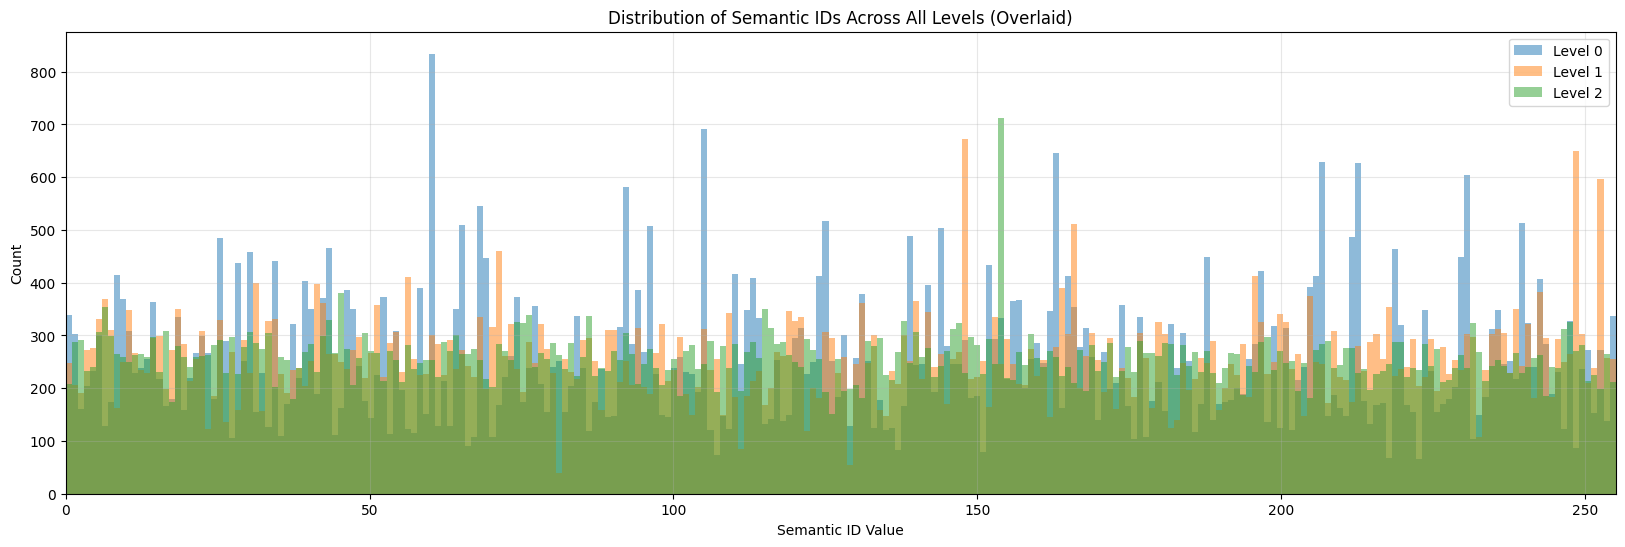

In [ ]:
# Alternative: Overlaid visualization to compare distributions
plt.figure(figsize=(20, 6))

for level in range(3):
    col_name = f"semantic_id_{level}"
    values = result_df[col_name].to_list()
    plt.hist(values, bins=256, range=(0, 255), alpha=0.5, label=f"Level {level}", edgecolor="none")

plt.xlabel("Semantic ID Value")
plt.xlim(0, 255)
plt.ylabel("Count")
plt.title("Distribution of Semantic IDs Across All Levels (Overlaid)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()